In [82]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import datetime as dtm

from salishsea_tools import nc_tools, viz_tools

%matplotlib inline
mpl.rcParams.update({'font.size': 12})
mpl.rcParams["axes.formatter.useoffset"] = False

warnings.simplefilter("ignore")

In [83]:
def load_NEMO_currents(version, datein):
    '''Loads Salish Sea NEMO currents into variables
    '''
    
    # 3.4 or 3.6
    if version == '3.6':
        dirtag = '-green'
    else:
        dirtag = ''
    
    # Parse datein
    rundate = dtm.datetime.strptime(datein,'%Y-%b-%d').date()
    
    # Load netCDF binaries
    u_vel = nc.Dataset('/results/SalishSea/nowcast{dirtag}/{date1}/SalishSea_1d_{date2}_{date3}_grid_U.nc'.format(
            dirtag=dirtag, date1=rundate.strftime('%d%b%y').lower(), date2=rundate.strftime('%Y%m%d'),
            date3=rundate.strftime('%Y%m%d')))
    v_vel = nc.Dataset('/results/SalishSea/nowcast{dirtag}/{date1}/SalishSea_1d_{date2}_{date3}_grid_V.nc'.format(
            dirtag=dirtag, date1=rundate.strftime('%d%b%y').lower(), date2=rundate.strftime('%Y%m%d'),
            date3=rundate.strftime('%Y%m%d')))
    
    return u_vel, v_vel

In [84]:
def plot_horz_currents(ax, lons, lats, ugrid, vgrid, zlevel=0, t=0):
    ''' Plot horizontal currents from southern Gulf Islands to Howe Sound
    '''
    
    # Load grid to retrieve map coords
    grid = nc.Dataset('../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
    
    # Slicing parameters
    vel_grid = lons.shape
    y_slice = np.arange(vel_grid[0])
    x_slice = np.arange(vel_grid[1])
    lats_slice = lats[0:vel_grid[0], 0:vel_grid[1]]
    lons_slice = lons[0:vel_grid[0], 0:vel_grid[1]]
    
    # Slice u, v and unstagger
    ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel, y_slice, x_slice], 0)
    vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, y_slice, x_slice], 0)
    u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
    
    # Transform velocities from grid to map coords
    theta_rad = 29 * np.pi / 180
    u_E = u_tzyx * np.cos(theta_rad) - v_tzyx * np.sin(theta_rad)
    v_N = u_tzyx * np.sin(theta_rad) + v_tzyx * np.cos(theta_rad)
    
    # Make figure
    viz_tools.set_aspect(ax)
    ax.quiver(lons_slice[1::5, 1::5], lats_slice[1::5, 1::5], u_E[::5,::5], v_N[::5,::5], scale=10)
    viz_tools.plot_land_mask(ax, grid, coords='map', color='burlywood')
    
    # Formatting
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid()

In [85]:
def plot_alongshore_currents(ax, lons, ugrid, vgrid, zlevels, zmax, ylocn, section_slice, t=0):
    ''' Plot alongshore currents from southern Gulf Islands to Howe Sound
    '''
    
    # Load grid to retrieve map coords
    grid = nc.Dataset('../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
    
    # Slice and mask the v array
    vgrid_tzyx = np.ma.masked_values(vgrid[t, :zmax, ylocn, section_slice], 0)

    # Plot the v velocity colour mesh
    cmap = plt.get_cmap('bwr')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(lons[ylocn, section_slice[:]], zlevels[:zmax], vgrid_tzyx, cmap=cmap, vmin=-0.1, vmax=0.1)
    ax.invert_yaxis()

    # Formatting
    ax.set_xlabel('Longitude')
    ax.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
    ax.set_xlim(lons[ylocn, section_slice[1]], lons[ylocn, section_slice[-1]])
    ax.set_ylim(zlevels[zmax - 2] + 10, 0)
    ax.set_axis_bgcolor('burlywood')
    ax.grid()
    
    return mesh

In [86]:
def make_plots(datein):
    '''Plot nowcast and nowcast-green velocity fields
    '''
    
    # Plotting parameters
    zmax, ylocn = 40, 455
    section_slice = np.arange(238, 318)
    map_bounds = np.array([-124, -123, 48.5, 49.7])
    version = np.array(['3.4', '3.6'])
    
    # Make figure
    fig, ax = plt.subplots(2, 2, figsize=(15, 20))
    
    for i in np.arange(2):
        
        # Load NEMO results
        u_vel, v_vel = load_NEMO_currents(version[i], datein)
        
        # Define subfields
        ugrid     = u_vel.variables['vozocrtx']
        vgrid     = v_vel.variables['vomecrty']
        zlevels   = u_vel.variables['depthu']
        lats      = u_vel.variables['nav_lat']
        lons      = u_vel.variables['nav_lon']
        timestamp = nc_tools.timestamp(u_vel, 0, version=version[i])
        
        # Plot surface currents
        plot_horz_currents(ax[0, i], lons, lats, ugrid, vgrid)
        ax[0, i].plot(lons[ylocn, section_slice], lats[ylocn, section_slice],
                   linestyle='solid', linewidth=3, color='black', label='Section Line')
        ax[0, i].set_xlim(map_bounds[0:2])
        ax[0, i].set_ylim(map_bounds[2:4])
        ax[0, i].set_title('NEMO {version}, {date}'.format(
                version=version[i], date=timestamp.format('DD-MMM-YYYY HH:MM')))
        
        # Plot alongshore currents
        mesh = plot_alongshore_currents(ax[1, i], lons, ugrid, vgrid, zlevels, zmax, ylocn, section_slice)
        ax[1, i].set_xticks(np.arange(-123.6, -123.2, 0.1))
        cbar = fig.colorbar(mesh, ax=ax[1, i], orientation='horizontal')
        cbar.set_ticks(np.arange(-.1, .101, .05))
        cbar.set_label('v Velocity [{.units}]'.format(vgrid))
        ax[1, i].set_title('NEMO {version}, {date}'.format(version=version[i], date=timestamp.format('DD-MMM-YYYY HH:MM')))

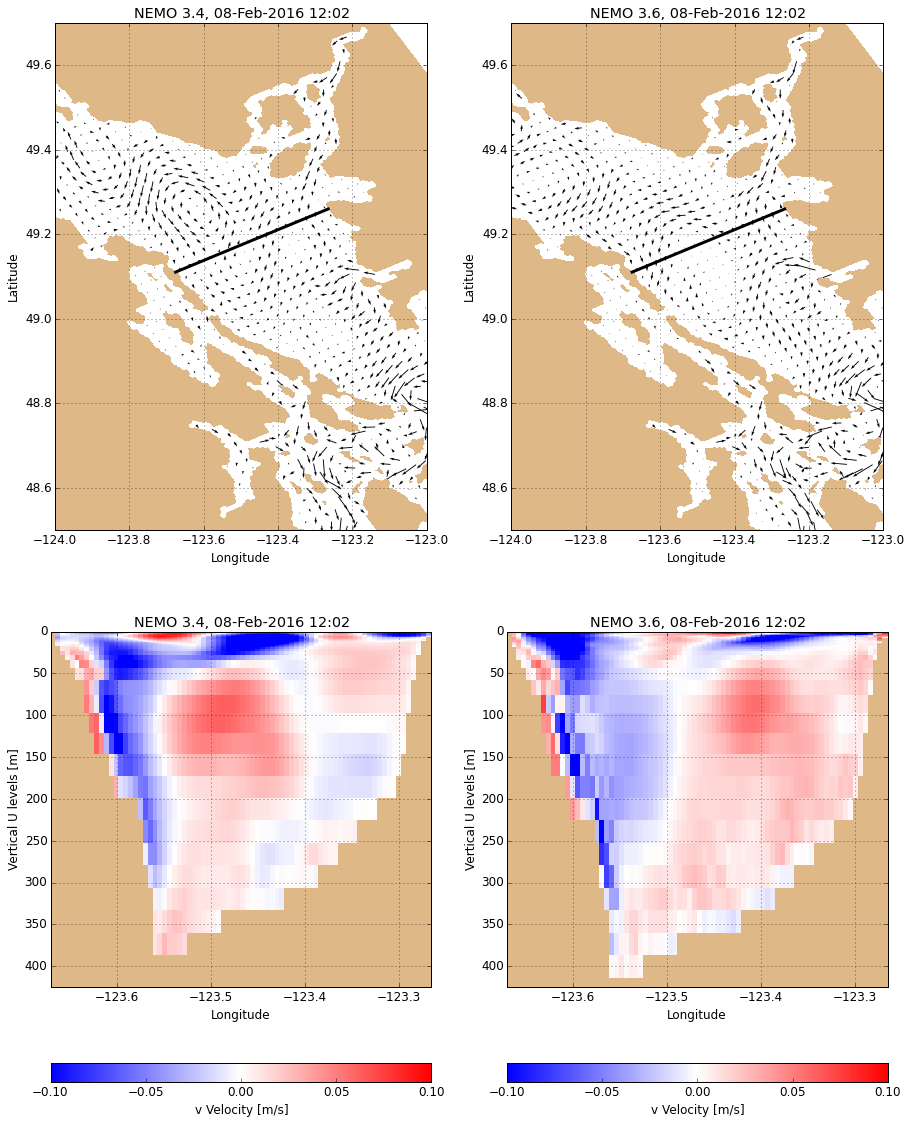

In [87]:
make_plots('2016-feb-08')